In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scipy.stats import ks_2samp
from optbinning import Scorecard
from optbinning import BinningProcess
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

(CVXPY) Nov 06 10:42:23 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 06 10:42:23 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


# Cargamos y transformamos nuestros datos

In [2]:
df = pd.read_csv('credit_card_default.csv')

# transformacion ----------------------------
# Rename
df.rename(columns=lambda x: x.lower(), inplace=True) # pasa a minusculas los headers
df.rename(columns={'default payment next month':'default'}, inplace=True) # cambiamos el nombre de una columna
df.rename(columns={'pay_0':'pay_1'}, inplace=True) # cambiamos el nombre de una columna

# etiquetas de tipos de variables
bill_amt_features = ['bill_amt'+str(i) for i in range(1,7)]
pay_amt_features = ['pay_amt'+str(i) for i in range(1,7)]
numerical_features = ['limit_bal', 'age'] + bill_amt_features + pay_amt_features

# transformando el tipo de variables
df['male'] = (df['sex'] == 1).astype('int')
df['female'] = (df['sex'] == 2).astype('int')
df['grad_school'] = (df['education'] == 1).astype('int')
df['university'] = (df['education'] == 2).astype('int')
df['high_school'] = (df['education'] == 3).astype('int')
df['married'] = (df['marriage'] == 1).astype('int')

# transfromamos los valores con -1 o -2 a 0
pay_features = ['pay_'+str(i) for i in range(1,7)]
for x in pay_features:
    df.loc[df[x] <= 0, x] = 0

# creamos variables binarias
delayed_features = ['delayed_' + str(i) for i in range(1,7)]
for pay, delayed in zip(pay_features, delayed_features):
    df[delayed] = (df[pay] > 0).astype('int')

# creamos la columna de la suma de los atrasos de los ultimos meses
df['months_delayed'] = df[delayed_features].sum(axis=1)

# por ultimo solo nos quedamos con las variables de interes
numerical_features = numerical_features + ['months_delayed']
binary_features = ['male','female','married','grad_school', 'university','high_school']
x = df[numerical_features + binary_features]
y = df['default'].astype('int')

In [3]:
x.head()

,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,...,pay_amt4,pay_amt5,pay_amt6,months_delayed,male,female,married,grad_school,university,high_school
0,20000,24,3913,3102,689,0,0,0,0,689,...,0,0,0,2,0,1,1,0,1,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,1000,0,2000,2,0,1,0,0,1,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,1000,1000,5000,0,0,1,0,0,1,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,1100,1069,1000,0,0,1,1,0,1,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,9000,689,679,0,1,0,1,0,1,0


# dividimos nuestros datos en train y test

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

# escalamos los datos (solo las columnas numericas)
scaler = StandardScaler()
x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
x_test[numerical_features] = scaler.transform(x_test[numerical_features])

# Scorecard development

In [5]:
binning_process = BinningProcess(variable_names=x_train.columns.tolist())
binning_process.fit(x_train, y_train)

BinningProcess(variable_names=['limit_bal', 'age', 'bill_amt1', 'bill_amt2',
                               'bill_amt3', 'bill_amt4', 'bill_amt5',
                               'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
                               'pay_amt4', 'pay_amt5', 'pay_amt6',
                               'months_delayed', 'male', 'female', 'married',
                               'grad_school', 'university', 'high_school'])

In [6]:
# seleccionamos nuestro estimador
# que en este caso sera la regresion logistica
estimator = LogisticRegression()

scorecard = Scorecard(
    binning_process = binning_process,
    estimator = estimator
)
scorecard.fit(x_train, y_train, show_digits=4)

Scorecard(binning_process=BinningProcess(variable_names=['limit_bal', 'age',
                                                         'bill_amt1',
                                                         'bill_amt2',
                                                         'bill_amt3',
                                                         'bill_amt4',
                                                         'bill_amt5',
                                                         'bill_amt6',
                                                         'pay_amt1', 'pay_amt2',
                                                         'pay_amt3', 'pay_amt4',
                                                         'pay_amt5', 'pay_amt6',
                                                         'months_delayed',
                                                         'male', 'female',
                                                         'married',
                                                         'grad_school',
                                                         'university',
                                                         'high_school']),
          estimator=LogisticRegression())

In [7]:
scorecard.information(print_level=2)

optbinning (Version 0.20.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                        no   * d
    scaling_method_params                 no   * d
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                  21000
    Number of variables                   21
    Target type                       binary

    Number of numerical                   21
    Number of categorical                  0
    Number of selected                    21

  Timing
    Total time                          2.01 sec
    Binning process                     1.72 sec   ( 85.87%)
    Estimator                           0.13 sec   (  6.66%

In [8]:
scorecard.table(style="summary")

,Variable,Bin,Points
0,limit_bal,"(-inf, -1.1039)",0.219242
1,limit_bal,"[-1.1039, -0.9498)",0.196906
2,limit_bal,"[-0.9498, -0.7186)",0.074157
3,limit_bal,"[-0.7186, -0.4874)",0.052878
4,limit_bal,"[-0.4874, -0.1792)",0.015895
...,...,...,...
3,university,Missing,-0.000000
0,high_school,"(-inf, 0.5000)",-0.036493
1,high_school,"[0.5000, inf)",0.174053
2,high_school,Special,-0.000000


In [9]:
table = scorecard.table(style="detailed")
table

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,limit_bal,0,"(-inf, -1.1039)",1724,0.082095,1080,644,0.373550,-0.728230,0.051678,0.006321,-0.301061,0.219242
1,limit_bal,1,"[-1.1039, -0.9498)",1274,0.060667,820,454,0.356358,-0.654041,0.030368,0.003730,-0.301061,0.196906
2,limit_bal,2,"[-0.9498, -0.7186)",3407,0.162238,2490,917,0.269152,-0.246318,0.010506,0.001310,-0.301061,0.074157
3,limit_bal,3,"[-0.7186, -0.4874)",2282,0.108667,1699,583,0.255478,-0.175640,0.003514,0.000439,-0.301061,0.052878
4,limit_bal,4,"[-0.4874, -0.1792)",1950,0.092857,1496,454,0.232821,-0.052795,0.000263,0.000033,-0.301061,0.015895
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,university,3,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-1.585390,-0.000000
0,high_school,0,"(-inf, 0.5000)",17528,0.834667,13720,3808,0.217252,0.036502,0.001101,0.000138,-0.999746,-0.036493
1,high_school,1,"[0.5000, inf)",3472,0.165333,2586,886,0.255184,-0.174097,0.005251,0.000656,-0.999746,0.174053
2,high_school,2,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.999746,-0.000000


In [18]:
y_pred_train = scorecard.predict_proba(x_train)[:, 1]
y_pred_test = scorecard.predict_proba(x_test)[:, 1]

# calculamos las metricas para el entrenamiento
auc_roc_train = roc_auc_score(y_train, y_pred_train)
ks_stat_train, p_value_train = ks_2samp(y_pred_train[y_train == 0], y_pred_train[y_train == 1])
gini_train = 2*auc_roc_train-1

# calculamos las metricas para validacion
auc_roc_test = roc_auc_score(y_test, y_pred_test)
ks_stat_test, p_value_test = ks_2samp(y_pred_test[y_test == 0], y_pred_test[y_test == 1])
gini_test = 2*auc_roc_test-1

print("Metricas para el entrenamiento: \n" + f"AUC = {round(auc_roc_train,2)} \n" + f"KS = {round(ks_stat_train,2)} \n" + f"GINI = {round(gini_train,2)}")
print("Metricas para la validación: \n" + f"AUC = {round(auc_roc_test,2)} \n" + f"KS = {round(ks_stat_test,2)} \n" + f"GINI = {round(gini_test,2)}")

Metricas para el entrenamiento: 
AUC = 0.76 
KS = 0.41 
GINI = 0.53
Metricas para la validación: 
AUC = 0.76 
KS = 0.4 
GINI = 0.51


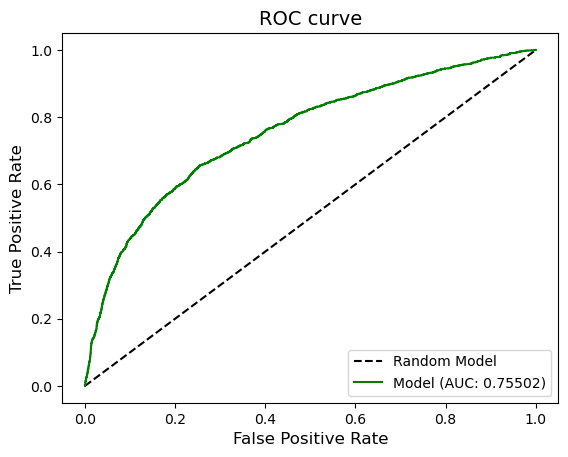

In [19]:
plot_auc_roc(y_test, y_pred_test)

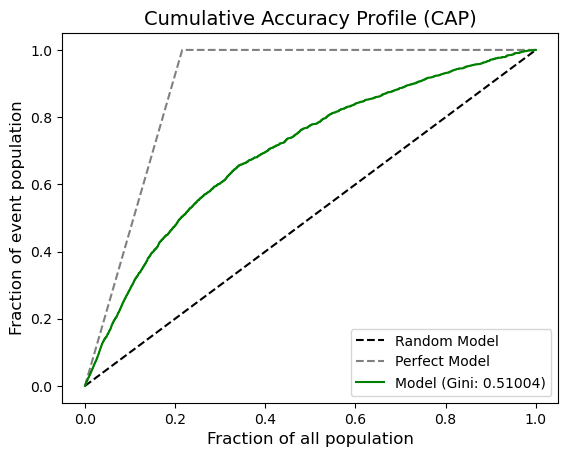

In [20]:
plot_cap(y_test, y_pred_test)

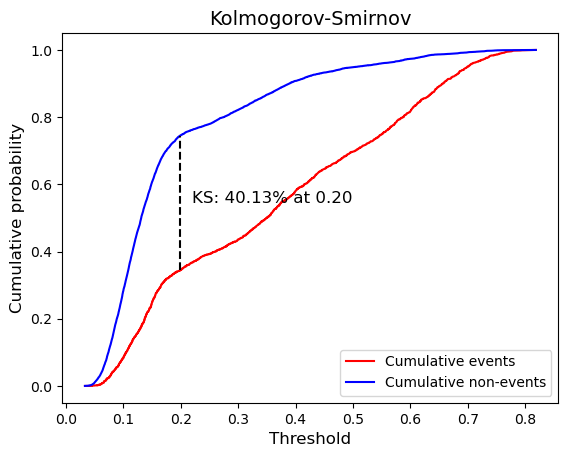

In [21]:
plot_ks(y_test, y_pred_test)

# cuales son nuestras variables finalistas?

In [22]:
iv_sorted = table[["Variable", "IV"]].dropna().groupby("Variable").IV.max().sort_values(ascending=False)
iv_sorted

Variable
months_delayed    0.308349
pay_amt1          0.095873
pay_amt2          0.077186
pay_amt3          0.062015
limit_bal         0.051678
pay_amt4          0.050142
pay_amt6          0.042092
pay_amt5          0.036389
bill_amt4         0.012977
bill_amt5         0.012113
bill_amt6         0.011346
grad_school       0.011133
bill_amt3         0.006757
high_school       0.005251
bill_amt1         0.005137
female            0.005091
male              0.005091
age               0.004621
married           0.004369
university        0.004206
bill_amt2         0.003486
Name: IV, dtype: float64

In [23]:
vars = ['bill_amt3', 'high_school', 'bill_amt1', 'female', 'male', 'age', 'married', 'university', 'bill_amt2', 'grad_school']
x_train_finalitas = x_train.drop(columns=vars)
x_test_finalistas = x_test.drop(columns=vars)
x_train_finalitas.head()

,limit_bal,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,months_delayed
12160,-1.065331,-0.651430,-0.640844,-0.628745,-0.277692,-0.239892,-0.211845,-0.287068,-0.283509,-0.291946,0.099721
1100,0.321616,-0.405881,-0.626207,-0.647999,-0.334689,0.449626,-0.288999,-0.163797,-0.293644,-0.071368,0.737596
22225,-0.680068,0.491573,0.561938,0.599624,-0.150647,-0.100467,-0.109697,-0.132172,-0.124146,-0.132027,-0.538154
6385,0.552774,-0.404381,-0.347916,-0.300306,0.704023,-0.160221,-0.180331,-0.183804,-0.117772,-0.181657,0.099721
22930,-0.603015,-0.492989,-0.644520,-0.652010,-0.046700,-0.188703,-0.125997,-0.236146,-0.309007,0.195091,-0.538154


In [24]:
binning_process_f = BinningProcess(variable_names=x_train_finalitas.columns.tolist())
binning_process_f.fit(x_train_finalitas, y_train)

BinningProcess(variable_names=['limit_bal', 'bill_amt4', 'bill_amt5',
                               'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
                               'pay_amt4', 'pay_amt5', 'pay_amt6',
                               'months_delayed'])

In [25]:
scorecard_f = Scorecard(
    binning_process = binning_process_f,
    estimator = estimator
)

scorecard_f.fit(x_train_finalitas, y_train)

Scorecard(binning_process=BinningProcess(variable_names=['limit_bal',
                                                         'bill_amt4',
                                                         'bill_amt5',
                                                         'bill_amt6',
                                                         'pay_amt1', 'pay_amt2',
                                                         'pay_amt3', 'pay_amt4',
                                                         'pay_amt5', 'pay_amt6',
                                                         'months_delayed']),
          estimator=LogisticRegression())

In [26]:
y_pred_f = scorecard_f.predict_proba(x_test_finalistas)[:, 1]

auc_roc_f = roc_auc_score(y_test, y_pred_f)
ks_stat_f, p_value_f = ks_2samp(y_pred_f[y_test == 0], y_pred_f[y_test == 1])
gini_f = 2*auc_roc_f-1

print("Metricas para variables finalistas: \n" + f"AUC = {round(auc_roc_f,2)} \n" + f"KS = {round(ks_stat_f,2)} \n" + f"GINI = {round(gini_f,2)}")

Metricas para variables finalistas: 
AUC = 0.75 
KS = 0.4 
GINI = 0.51


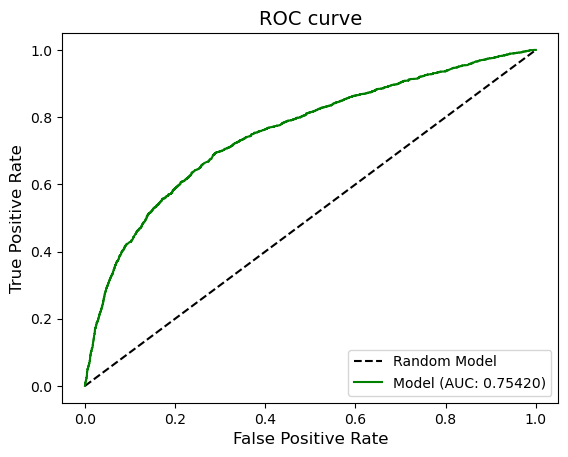

In [63]:
plot_auc_roc(y_test, y_pred_f)

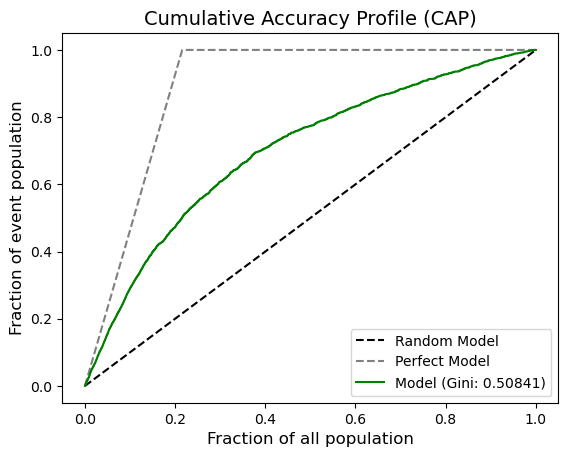

In [64]:
plot_cap(y_test, y_pred_f)

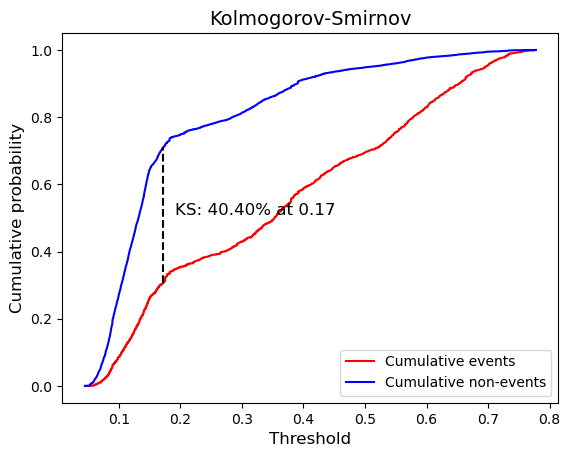

In [65]:
plot_ks(y_test, y_pred_f)

como vemmos a nuestro modelo le quitamos en su mayoria todas las variables que son binarias, ademas de bill_1, 2 y 3, y lo que vemos son practimente los mismos resultados en las metricas, es decir que estas variables que quitamos no nos proporcionaban inofrmación extra. 